### Calculating the IQR for a Monte Carlo ensemble

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

DEPTH = 11

In [2]:
R = 8.3145 # gas constant [J/Kmol]
C_OH = 4500 # Water content [H/Si ppm]
f_H2O = 4500 # Water fugacity [MPa]

In [3]:
# file names and the list of parameters associated with each column
names = ["rutter04ab_X.out","GT95_d_fixed.out","LP92_COH.out","fukuda18_d_fixed.out"]

file_names = {
    "rutter04ab_X.out":"run_id chi2(simplified) chi2(original) m Q_dif n Q_dis X X1 A_dif A_dis",
    "GT95_d_fixed.out":"run_id chi2(simplified) chi2(original) m Q_dif n Q_dis X X1 X2 X3 X4 A_dif A_dis",
    "LP92_COH.out":"run_id chi2(simplified) chi2(original) r n Q X X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 X13 A",
    "fukuda18_d_fixed.out":"run_id chi2(simplified) chi2(original) m r_dif Q_dif r_dis n Q_dis X X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 A_dif A_dis"
}
file = [[]]*len(file_names)

In [4]:
# importing MCMC inversion results
for i,name in enumerate(file_names):
    file[i] = pd.read_csv(name,delim_whitespace=True,names=list(str.split(file_names[names[i]])))

In [5]:
data = [[]]*len(file)
for i, df in enumerate(file):
    # drop interrun biases
    f = df[df.columns.drop(list(df.filter(regex='X')))]
    # skip first 1000 runs, then select sample from every 100 runs
    data[i] = f.iloc[100:-1:10,:]

In [6]:
data[2]

,run_id,chi2(simplified),chi2(original),r,n,Q,A
100,10100,79.185,4.829,1.08092,3.40896,143836.0,1.764990e-11
110,11100,103.544,5.501,1.07228,3.23351,170170.0,6.687400e-10
120,12100,81.574,4.987,1.10346,3.39752,101599.0,1.934480e-13
130,13100,71.899,5.458,1.05670,3.51408,109157.0,4.930490e-13
140,14100,87.029,4.819,1.07100,3.41688,138159.0,1.322880e-11
...,...,...,...,...,...,...,...
9950,995100,119.449,4.004,1.38154,3.42039,164784.0,1.219670e-11
9960,996100,128.143,5.649,1.06122,3.19781,101288.0,1.656420e-12
9970,997100,100.024,4.299,1.13159,3.53772,139041.0,3.256850e-12
9980,998100,126.122,3.822,1.47153,3.77739,137865.0,5.072810e-14


In [7]:
# import differential pressure data from isostasy_calculation

%store -r z
%store -r T
%store -r T_archean
%store -r data_P

present_day = data_P[0]
P_diff_present = [i[0] for i in present_day]
cc_present = [i[1] for i in present_day]
sigma = np.array(P_diff_present) # differential pressure [MPa]

archean = data_P[1]
P_diff_archean = [i[0] for i in archean]
cc_archean = [i[1] for i in archean]
sigma_archean = P_diff_archean

In [8]:
def calc_IQR_dis(data, T, sigma, flow_law="composite",water=0, V=False):
    """
    Calculates the interquartile range for dislocation flow law. Default calculation is for a dry composite inversion.
    data: dataframe of the processed .out file
    flow_law: the target flow law of the inversion ("composite", "dis")
    T: temperature profile [K]
    sigma: pressure profile [MPa]
    V: activation volume (not implemented)
    water: water content or fugacity in [H/Si ppm] or [MPa], respectively. If value is zero, assume dry inversion.

    """
    e, e_mean, e_25, e_75 = ([[[] for j in range(DEPTH)] for i in range(len(sigma))] for i in range(4))
    
    if flow_law=="composite":
        if not water:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A_dis'])*(sigma[j][i]+0.1)**np.array(data['n'])*np.exp(-np.array(data['Q_dis'])/(R*T[i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A_dis'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*np.exp(-np.mean(np.array(data['Q_dis']))/(R*T[i]))
        else:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A_dis'])*(sigma[j][i]+0.1)**np.array(data['n'])*water**np.array(data['r_dis'])*np.exp(-np.array(data['Q_dis'])/(R*T[i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A_dis'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*water**np.mean(np.array(data['r_dis']))*np.exp(-np.mean(np.array(data['Q_dis']))/(R*T[i]))
    elif flow_law=="dis":
        if not water:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A'])*(sigma[j][i]+0.1)**np.array(data['n'])*np.exp(-np.array(data['Q'])/(R*T[i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*np.exp(-np.mean(np.array(data['Q']))/(R*T[i]))
        else:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A'])*(sigma[j][i]+0.1)**np.array(data['n'])*water**np.array(data['r'])*np.exp(-np.array(data['Q'])/(R*T[i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*water**np.mean(np.array(data['r']))*np.exp(-np.mean(np.array(data['Q']))/(R*T[i]))
    else:
        print("Flow law not recognized.")
        return 1

    e_25 = [[np.percentile(j,25) for j in i] for i in e]
    e_75 = [[np.percentile(j,75) for j in i] for i in e]
    return [e_mean, e_25, e_75]

In [9]:
IQR = [[]]*len(file_names)
e_mean, e_25, e_75 = calc_IQR_dis(data[0],T, sigma)
IQR[0] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[1],T, sigma)
IQR[1] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[2],T, sigma, flow_law="dis",water=C_OH)
IQR[2] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[3],T, sigma, water=f_H2O)
IQR[3] = [e_mean, e_25, e_75]

In [10]:
IQR_archean = [[]]*len(file_names)
e_mean, e_25, e_75 = calc_IQR_dis(data[0],T_archean, sigma_archean)
IQR_archean[0] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[1],T_archean, sigma_archean)
IQR_archean[1] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[2],T_archean, sigma_archean, flow_law="dis",water=C_OH)
IQR_archean[2] = [e_mean, e_25, e_75]

e_mean, e_25, e_75 = calc_IQR_dis(data[3],T_archean, sigma_archean, water=f_H2O)
IQR_archean[3] = [e_mean, e_25, e_75]

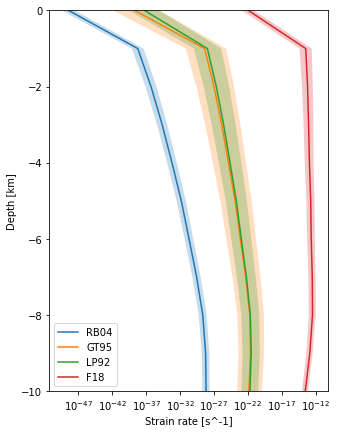

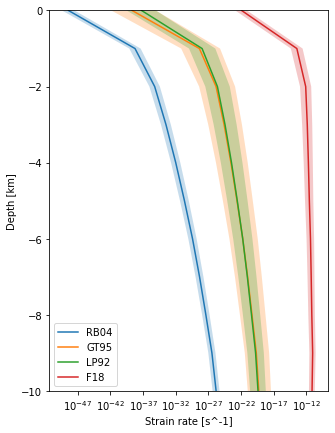

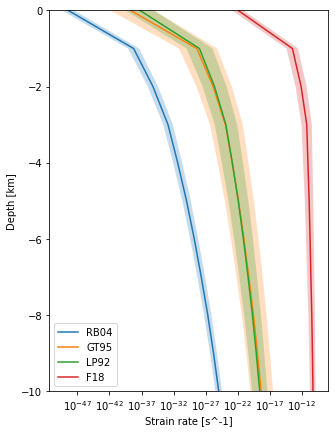

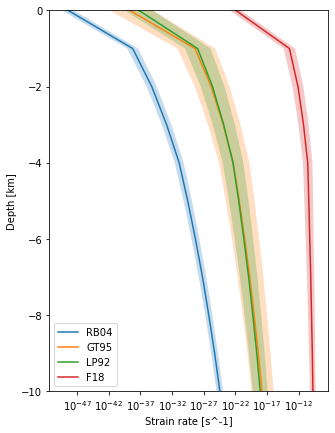

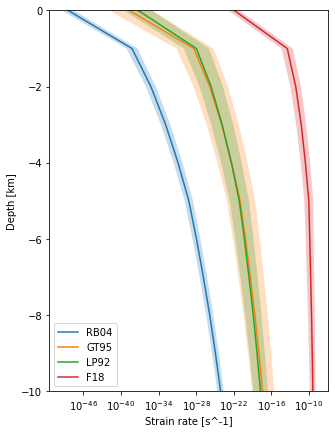

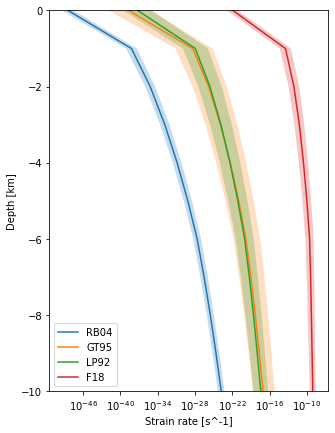

In [11]:
names_shortened = ['RB04','GT95','LP92','F18']

for j in range(len(sigma)):
    plt.figure(figsize=(5,7))
    for i,iqr in enumerate(IQR):
        plt.semilogx(iqr[0][j],-z[:DEPTH]/1000)
        plt.fill_betweenx(-z[:DEPTH]/1000, iqr[1][j], iqr[2][j], alpha=0.25)
    plt.ylim(-(DEPTH-1),0)
    plt.xlabel('Strain rate [s^-1]')
    plt.ylabel('Depth [km]')
    plt.legend(names_shortened)    
    plt.show()

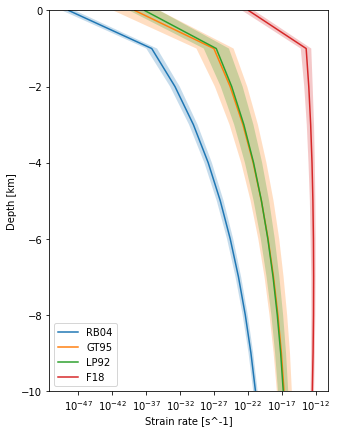

In [12]:
for j in range(len(sigma_archean)):
    plt.figure(figsize=(5,7))
    for i,iqr in enumerate(IQR_archean):
        plt.semilogx(iqr[0][j],-z[:DEPTH]/1000)
        plt.fill_betweenx(-z[:DEPTH]/1000, iqr[1][j], iqr[2][j], alpha=0.25)
    plt.ylim(-(DEPTH-1),0)
    plt.xlabel('Strain rate [s^-1]')
    plt.ylabel('Depth [km]')
    plt.legend(names_shortened)    
    plt.show()

In [13]:
%store IQR
del IQR

Stored 'IQR' (list)


In [14]:
%store IQR_archean
del IQR_archean

Stored 'IQR_archean' (list)
